In [ ]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBClassifier

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    f1_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [3]:
# Random Seed
random_state = 33
np.random.seed(random_state)

In [4]:
# plt style
plt.style.use("seaborn-v0_8-darkgrid")

In [5]:
# Dataset
PROJECT_DIR = Path.cwd().parent

parq_path = PROJECT_DIR / "data" / "all_stats.parquet"
df = pd.read_parquet(parq_path)
df.head()


,flight_id,before_after,date_diff,flight_length,label,num_flights_before,volt1_mean,volt1_std,volt1_min,volt1_max,...,NormAc_p25,NormAc_p75,AltMSL_mean,AltMSL_std,AltMSL_min,AltMSL_max,AltMSL_range,AltMSL_p25,AltMSL_p75,AltMSL_rate_mean
0,1,before,-1,4723.0,intake gasket leak/damage,-1,28.780796,4.712894e-02,28.7,29.3,...,-0.01,0.01,2764.796803,1616.009723,835.6,5162.4,4326.8,842.55,4048.9,0.000275
1,2,before,-2,4649.0,intake gasket leak/damage,-2,27.831276,7.633934e-01,25.0,28.2,...,-0.03,0.04,2205.734739,1287.575722,824.1,5261.6,4437.5,887.00,3509.8,-0.001678
2,3,same,0,40.0,intake gasket leak/damage,0,24.900000,3.600403e-15,24.9,24.9,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,before,0,14.0,intake gasket leak/damage,0,25.400000,3.697782e-15,25.4,25.4,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,same,0,683.0,intake gasket leak/damage,0,26.945095,1.271312e+00,24.6,28.1,...,-0.02,0.02,832.528006,5.235779,812.9,846.0,33.1,831.60,835.4,0.031571


In [6]:
# add cluster (target) column
json_path = PROJECT_DIR / "data" / "label_cluster_map.json"
assert json_path.exists()

with json_path.open() as fp:
    label_cluster_map = json.loads(fp.read())

df["cluster"] = df["label"].map(label_cluster_map)

In [7]:
# weighted labels
sort_by = "weight_total_impact"

weighted_labels_path = PROJECT_DIR / "data" / "weighted_labels.csv"
weighted_labels_df = pd.read_csv(weighted_labels_path, index_col=0)
weighted_labels_df.sort_values(by=sort_by, ascending=False).head()

,label,count,price_usd,weight_norm,weight_total_impact,risk_factor,weight_risk_factor
7,engine run rough,670,839.99,0.383613,562793.30,1.4,27185.660955
3,baffle crack/damage/loose/miss,1294,419.95,0.237344,543415.30,1.3,34472.789022
9,engine failure/fire/time out,643,839.99,0.382277,540113.57,2.0,37271.599134
10,cylinder compression issue,617,795.00,0.362015,490515.00,1.7,29574.516259
17,oil cooler need maintenance,312,1189.00,0.513092,370968.00,1.4,15061.684878


In [8]:
# limit labels and apply filters
num_labels = 5

LABELS = weighted_labels_df.sort_values(by=sort_by, ascending=False)["label"].values[
    :num_labels
]
label_mask = df["label"].isin(LABELS)

# look only at flights before maintenance
before_mask = df["before_after"] == "before"

df_before = df[label_mask & before_mask]

## Label Distribution

In [9]:
y_full = df_before["cluster"]
class_counts = y_full.value_counts().sort_index()
for cluster in class_counts.index:
    count = class_counts[cluster]
    pct = count / len(y_full) * 100
    print(f"{cluster=}, {pct=:0.2f}")

cluster=4, pct=35.93
cluster=13, pct=19.91
cluster=21, pct=15.56
cluster=24, pct=20.50
cluster=32, pct=8.11


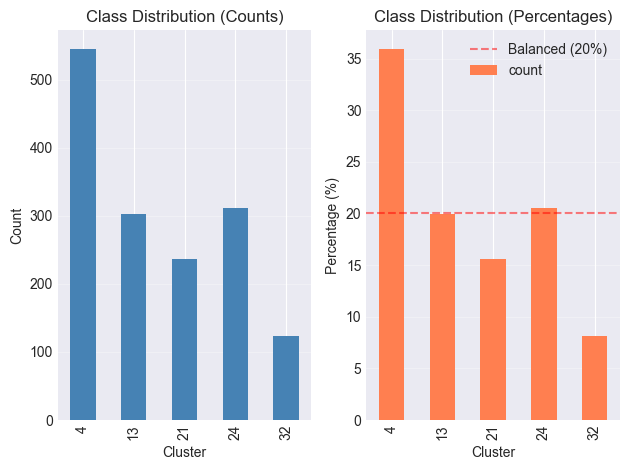

imbalance_ratio=4.43


In [10]:
# Visualize
fig, ax = plt.subplots(1, 2)
class_counts.plot(kind="bar", ax=ax[0], color="steelblue")
ax[0].set_title("Class Distribution (Counts)")
ax[0].set_xlabel("Cluster")
ax[0].set_ylabel("Count")
ax[0].grid(axis="y", alpha=0.3)

class_pcts = class_counts / len(y_full) * 100
class_pcts.plot(kind="bar", ax=ax[1], color="coral")
ax[1].set_title("Class Distribution (Percentages)")
ax[1].set_xlabel("Cluster")
ax[1].set_ylabel("Percentage (%)")
ax[1].axhline(y=20, linestyle="--", color="red", alpha=0.5, label="Balanced (20%)")
ax[1].legend()
ax[1].grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# imbalance ratio
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"{imbalance_ratio=:.2f}")

In [11]:
# Choose features for training
all_features = [
    "AltMSL_max",
    "AltMSL_mean",
    "AltMSL_min",
    "AltMSL_p25",
    "AltMSL_p75",
    "AltMSL_range",
    "AltMSL_rate_mean",
    "AltMSL_std",
    "E1_CHT1_max",
    "E1_CHT1_mean",
    "E1_CHT1_min",
    "E1_CHT1_p25",
    "E1_CHT1_p75",
    "E1_CHT1_std",
    "E1_CHT2_max",
    "E1_CHT2_mean",
    "E1_CHT2_min",
    "E1_CHT2_p25",
    "E1_CHT2_p75",
    "E1_CHT2_std",
    "E1_CHT3_max",
    "E1_CHT3_mean",
    "E1_CHT3_min",
    "E1_CHT3_p25",
    "E1_CHT3_p75",
    "E1_CHT3_std",
    "E1_CHT4_max",
    "E1_CHT4_mean",
    "E1_CHT4_min",
    "E1_CHT4_p25",
    "E1_CHT4_p75",
    "E1_CHT4_std",
    "E1_CHT_max_all",
    "E1_CHT_mean_all",
    "E1_CHT_min_all",
    "E1_CHT_rate_max",
    "E1_CHT_spread_mean",
    "E1_CHT_std_all",
    "E1_EGT1_max",
    "E1_EGT1_mean",
    "E1_EGT1_min",
    "E1_EGT1_p25",
    "E1_EGT1_p75",
    "E1_EGT1_std",
    "E1_EGT2_max",
    "E1_EGT2_mean",
    "E1_EGT2_min",
    "E1_EGT2_p25",
    "E1_EGT2_p75",
    "E1_EGT2_std",
    "E1_EGT3_max",
    "E1_EGT3_mean",
    "E1_EGT3_min",
    "E1_EGT3_p25",
    "E1_EGT3_p75",
    "E1_EGT3_std",
    "E1_EGT4_max",
    "E1_EGT4_mean",
    "E1_EGT4_min",
    "E1_EGT4_p25",
    "E1_EGT4_p75",
    "E1_EGT4_std",
    "E1_EGT_max_all",
    "E1_EGT_mean_all",
    "E1_EGT_min_all",
    "E1_EGT_rate_max",
    "E1_EGT_spread_mean",
    "E1_EGT_std_all",
    "E1_FFlow_max",
    "E1_FFlow_mean",
    "E1_FFlow_min",
    "E1_FFlow_p25",
    "E1_FFlow_p75",
    "E1_FFlow_std",
    "E1_OilP_mean",
    "E1_OilP_min",
    "E1_OilP_p25",
    "E1_OilP_p75",
    "E1_OilP_std",
    "E1_OilT_max",
    "E1_OilT_mean",
    "E1_OilT_min",
    "E1_OilT_p25",
    "E1_OilT_p75",
    "E1_OilT_rate",
    "E1_OilT_std",
    "E1_RPM_max",
    "E1_RPM_mean",
    "E1_RPM_min",
    "E1_RPM_p25",
    "E1_RPM_p75",
    "E1_RPM_std",
    "FQtyL_consumed",
    "FQtyL_end",
    "FQtyL_max",
    "FQtyL_mean",
    "FQtyL_min",
    "FQtyL_p25",
    "FQtyL_p75",
    "FQtyL_rate",
    "FQtyL_start",
    "FQtyL_std",
    "FQtyR_consumed",
    "FQtyR_end",
    "FQtyR_max",
    "FQtyR_mean",
    "FQtyR_min",
    "FQtyR_p25",
    "FQtyR_p75",
    "FQtyR_rate",
    "FQtyR_start",
    "FQtyR_std",
    "IAS_max",
    "IAS_mean",
    "IAS_min",
    "IAS_p25",
    "IAS_p75",
    "IAS_rate_mean",
    "IAS_std",
    "NormAc_max",
    "NormAc_mean",
    "NormAc_min",
    "NormAc_p25",
    "NormAc_p75",
    "NormAc_std",
    "OAT_max",
    "OAT_mean",
    "OAT_min",
    "OAT_p25",
    "OAT_p75",
    "OAT_std",
    "VSpd_max",
    "VSpd_mean",
    "VSpd_min",
    "VSpd_p25",
    "VSpd_p75",
    "VSpd_std",
    "amp1_max",
    "amp1_mean",
    "amp1_min",
    "amp1_p25",
    "amp1_p75",
    "amp1_std",
    "amp2_max",
    "amp2_mean",
    "amp2_min",
    "amp2_p25",
    "amp2_p75",
    "amp2_std",
    # "date_diff",
    # "flight_length",
    "fuel_imbalance_max",
    "fuel_imbalance_mean",
    # "num_flights_before",
    "volt1_max",
    "volt1_mean",
    "volt1_min",
    "volt1_p25",
    "volt1_p75",
    "volt1_std",
    "volt2_max",
    "volt2_mean",
    "volt2_min",
    "volt2_p25",
    "volt2_p75",
    "volt2_std",
]

## Train-Test Split

In [12]:
# Split into X, y with all features
X_all = df_before[all_features].copy()
y_all = df_before["cluster"].copy()

# Remove rows with any NaN values
nan_mask = ~X_all.isna().any(axis=1)
X = X_all[nan_mask]
y = y_all[nan_mask]

# Check for NaN, inf
assert not X.isna().any().any()
assert not np.isinf(X).any().any()

XGBoost expects sequential integer class labels, so we make sure they're valid inputs

In [13]:
#Grab all unique labels
labels = list(y.unique())

num = 0
map = {}

for l in labels:
    map[l] = num
    num += 1

y = y.map(map)    #replace old labels with new ones

#------------test-------------
#print(y)

In [14]:
# train-test split with stratification
test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=test_size,
    random_state=random_state,
    stratify=y,
)

Now we initialize XGBoost classifier

In [15]:
xgb_model = XGBClassifier(
    n_estimators=100, 
    max_depth=6, 
    learning_rate=1, 
    objective='binary:logistic'
    )

In [16]:
xgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    #verbose=True
)

[0]	validation_0-mlogloss:1.47590
[1]	validation_0-mlogloss:1.48301
[2]	validation_0-mlogloss:1.48483
[3]	validation_0-mlogloss:1.48481
[4]	validation_0-mlogloss:1.48577
[5]	validation_0-mlogloss:1.43997
[6]	validation_0-mlogloss:1.43966
[7]	validation_0-mlogloss:1.44474
[8]	validation_0-mlogloss:1.44660
[9]	validation_0-mlogloss:1.44187
[10]	validation_0-mlogloss:1.44871
[11]	validation_0-mlogloss:1.43553
[12]	validation_0-mlogloss:1.45518
[13]	validation_0-mlogloss:1.46932
[14]	validation_0-mlogloss:1.47545
[15]	validation_0-mlogloss:1.47409
[16]	validation_0-mlogloss:1.47589
[17]	validation_0-mlogloss:1.47496
[18]	validation_0-mlogloss:1.48867
[19]	validation_0-mlogloss:1.49026
[20]	validation_0-mlogloss:1.49119
[21]	validation_0-mlogloss:1.50085
[22]	validation_0-mlogloss:1.50231
[23]	validation_0-mlogloss:1.51113
[24]	validation_0-mlogloss:1.50912
[25]	validation_0-mlogloss:1.51074
[26]	validation_0-mlogloss:1.51122
[27]	validation_0-mlogloss:1.51464
[28]	validation_0-mlogloss:1.5

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [17]:
y_pred = xgb_model.predict(X_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

NameError: name 'accuracy_score' is not defined